<a href="https://colab.research.google.com/github/rahiakela/hands-on-unsupervised-learning-using-python/blob/main/2-end-to-end-machine-learning-project/2_part_1_machine_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part-1:Machine Learning Models

Before we begin exploring unsupervised learning algorithms in detail, we will
review how to set up and manage machine learning projects, covering everything
from acquiring data to building and evaluating a model and implementing a
solution. We will work with supervised learning models—an area most readers should have some experience in—before jumping into unsupervised learning models.

## Setup

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
import lightgbm as lgb

Let's download creditcardfraud dataset from [Kaggle](https://www.kaggle.com/isaikumar/creditcardfraud).

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

In [3]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download word embeddings from kaggle
kaggle datasets download -d isaikumar/creditcardfraud
unzip -qq creditcardfraud.zip
rm -rf creditcardfraud.zip

kaggle.json
 93% 61.0M/65.9M [00:00<00:00, 59.5MB/s]
100% 65.9M/65.9M [00:00<00:00, 122MB/s] 


## Loading dataset

We will use a real dataset of anonymized credit card transactions
made by [European cardholders from September 2013](https://www.kaggle.com/isaikumar/creditcardfraud). These transactions are labeled as fraudulent or genuine, and we will build a fraud detection solution using machine learning to predict the correct labels for never-before-seen instances.

This dataset is highly imbalanced. Of the 284,807 transactions, only 492 are
fraudulent (0.172%). This low percentage of fraud is pretty typical for credit
card transactions.

There are 28 features, all of which are numerical, and there are no categorical
variables. These features are not the original features but rather the output of
principal component analysis. The original features were distilled to 28 principal components using this form of dimensionality reduction.

## Data Acquisition

The first step in any machine learning project is data acquisition.

In [4]:
# Read the data
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Generate Feature Matrix and Labels Array

Let’s create and standardize the feature matrix X and isolate the labels array y
(one for fraud, zero for not fraud). 

Later on we will feed these into the machine learning algorithms during training.

In [5]:
# Create the feature matrix X and the labels array Y
data_x = data.copy().drop(["Class"], axis=1)
data_y = data["Class"].copy()

In [6]:
data_x.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Let’s rescale the feature matrix so that each feature, except for time, has a mean of zero and standard deviation of one.

In [7]:
# Standardize the feature matrix X
features_to_scale = data_x.drop(["Time"], axis=1).columns
sx = pp.StandardScaler(copy=True)
data_x.loc[:, features_to_scale] = sx.fit_transform(data_x[features_to_scale])

##Data Visualization

As a final step, let’s visualize the data to appreciate just how imbalanced the
dataset is.Since there are so few cases of fraud to learn from, this is
a difficult problem to solve; fortunately, we have labels for the entire dataset.

Text(0, 0.5, 'Frequency Percentage')

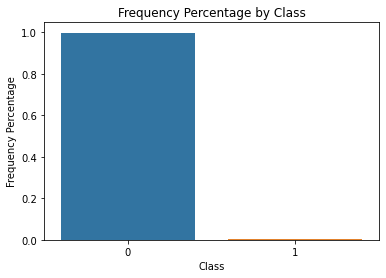

In [8]:
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=[tuple(count_classes/len(data))[0],tuple(count_classes/len(data))[1]])
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')

##Model Preparation

Now that the data is ready, let’s prepare for the model. We need to split the data
into a training and a test set, select a cost function, and prepare for k-fold crossvalidation.

###Split into Training and Test Sets

We need to set up our machine learning project so that we have a training set
from which the machine learning algorithm learns. We also need a test set (the
never-before-seen cases) the machine learning algorithm can make predictions
on. The performance on this test set will be the ultimate gauge of success.

Let’s go ahead and split our credit card transactions dataset into a training set and a test set.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=2020, stratify=data_y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(190820, 30) (190820,)
(93987, 30) (93987,)


To preserve the percentage of fraud (~0.17%) for both the training and the test set, we have set the stratify parameter.

###Feature scaling

In [10]:
# Feature scaling
features_to_scale = data_x.drop(['Time'],axis=1).columns
features_to_scale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [12]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

sx = pp.StandardScaler(copy=True)
x_train.loc[:, features_to_scale] = sx.fit_transform(x_train.loc[:, features_to_scale])
scaling_factors = pd.DataFrame(data=[sx.mean_, sx.scale_],index=['Mean','StDev'], columns=features_to_scale)

x_test.loc[:, features_to_scale] = sx.transform(x_test.loc[:, features_to_scale])

scaling_factors

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,0.000221,-0.001008,-0.002144,0.000016,-0.000134,-0.000977,0.001089,-0.001113,-0.000303,-0.000981,-0.000372,0.000391,-0.001872,0.000218,0.000298,0.000129,0.000045,0.002538,-0.003456,-0.001382,-0.000735,0.001905,0.000184,0.000988,-0.001237,0.003105,-0.002765,0.001606,0.000832
StDev,1.003017,1.005316,1.002874,1.001470,1.012178,1.005301,1.015145,1.001745,0.998685,0.994373,0.999072,0.995072,0.998671,0.996406,0.998960,0.996890,0.995264,1.001107,0.999722,1.012138,0.998972,0.999236,1.010673,0.998968,1.001821,1.001085,1.004932,1.030749,1.012571


###Create k-Fold Cross-Validation Sets

To help the machine learning algorithm estimate what its performance will be on
the never-before-seen examples (the test set), it is best practice to further split the training set into a training set and a validation set.

It is possible to train and evaluate like this five times—leaving aside a different
fifth slice as the validation set each time. This is known as k-fold crossvalidation,
where k in this case is five. With this approach, we will have not one
estimate but five estimates for the generalization error.

We will store the training score and the cross-validation score for each of the
five runs, and we will store the cross-validation predictions each time. After all
five runs are complete, we will have cross-validation predictions for the entire
dataset. This will be the best all-in estimate of the performance the test set.

In [13]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

##Model #1: Logistic Regression

Now we’re ready to build the machine learning models. For each machine
algorithm we consider, we will set hyperparameters, train the model, and
evaluate the results.

Let’s start with the most basic classification algorithm, logistic regression.

In [14]:
penalty = 'l2'              # set the penalty to the default value L2 instead of L1
C = 1.0                     # C is the regularization strength
class_weight = 'balanced'   # This signals to the logistic regression algorithm that we have an imbalanced class problem
random_state = 2018
solver = 'liblinear'
n_jobs = 1

###Train the model

We will train the logistic regression model on each of the five k-fold cross-validation splits, training on four-fifths of the training set and evaulating the performance on the fifth slice that is held aside.

In [15]:
log_reg = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, random_state=random_state, solver=solver, n_jobs=n_jobs)

In [17]:
training_scores = []
cv_scores = []
predictions_based_on_kfolds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
  x_train_fold, x_cv_fold = x_train.iloc[train_index, :], x_train.iloc[cv_index, :]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  log_reg.fit(x_train_fold, y_train_fold)

  logloss_training = log_loss(y_train_fold, log_reg.predict_proba(x_train_fold)[:, 1])
  training_scores.append(logloss_training) 

  predictions_based_on_kfolds.loc[x_cv_fold.index, :] = log_reg.predict_proba(x_cv_fold)
  logloss_cv = log_loss(y_cv_fold, predictions_based_on_kfolds.loc[x_cv_fold.index, 1])
  cv_scores.append(logloss_cv)

  print("Training Log Loss:", logloss_training)
  print("CV Log Loss:", logloss_cv)

logloss_logistic_regression = log_loss(y_train, predictions_based_on_kfolds.loc[:, 1])
print("Logistic Regression Log Loss: ", logloss_logistic_regression) 

Training Log Loss: 0.1115914084503823
CV Log Loss: 0.11072278047852098
Training Log Loss: 0.11582744695384373
CV Log Loss: 0.1176725688814084
Training Log Loss: 0.11568628386826778
CV Log Loss: 0.11335074816942886
Training Log Loss: 0.11962887546060656
CV Log Loss: 0.12090553843535343
Training Log Loss: 0.12076096303135772
CV Log Loss: 0.12339754424049496
Logistic Regression Log Loss:  0.11720983604104132


For each of the five runs, their training and cross-validation log losses are
similar. The logistic regression model does not exhibit severe overfitting; if it did, we would have a low training log loss and comparably high cross-validation log loss.

###Evaluation Metrics